In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ',\
                            parse_dates=["date", "dst_date"], infer_datetime_format=True)
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Filter out some values where number of datapoints are pretty low.
countDF = velGmagDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velGmagDF = pandas.merge( velGmagDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
allSapsVelsDF = velGmagDF
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,-4.0,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",731,-575,-210,156,0,2677
1,-4.0,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",651,-524,-199,127,2,2677
2,-4.0,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",586,-470,-177,116,4,2677
3,-4.0,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",562,-418,-137,144,6,2677
4,-4.0,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19.0,"(-25, -10]",569,-450,-166,119,8,2677


In [4]:
# Get a count of all saps events by Dst_index
# countAllSapsDstDF = velGmagDF.groupby( ["dtStr", "hour"] ).count().reset_index()
countAllSapsDstDF = velGmagDF[ ["dtStr", "hour", "dst_bin"] ]
countAllSapsDstDF["dtStr-hour"] = countAllSapsDstDF["dtStr"].astype(str) +\
                                "-" + countAllSapsDstDF["hour"].astype(str)
countAllSapsDstDF = countAllSapsDstDF.groupby( ["dst_bin"] )\
                    ["dtStr-hour"].aggregate(lambda x: len(list(set(x)))).reset_index()
countAllSapsDstDF.columns = [ "dst_bin", "allSAPSCount" ]
countAllSapsDstDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dst_bin,allSAPSCount
0,"(-10, 10]",89
1,"(-150, -75]",55
2,"(-25, -10]",192
3,"(-50, -25]",247
4,"(-75, -50]",71


In [5]:
# Lets get max, min and std.dev across each MLT for each time
# this way we'll try to isolate SAID channels
maxVelDF = velGmagDF.groupby( ["date", "normMLT"] )[ "vSaps", "azim", "MLAT" ].max().reset_index()
maxVelDF.rename(columns={'vSaps': 'vSapsMax','azim': 'azimMax','MLAT': 'mlatMax'}, inplace=True)

minVelDF = velGmagDF.groupby( ["date", "normMLT"] )[ "vSaps", "azim", "MLAT" ].min().reset_index()
minVelDF.rename(columns={'vSaps': 'vSapsMin','azim': 'azimMin','MLAT': 'mlatMin'}, inplace=True)

medianVelDF = velGmagDF.groupby( ["date", "normMLT"] )[ "vSaps", "azim", "MLAT" ].median().reset_index()
medianVelDF.rename(columns={'vSaps': 'vSapsMedian','azim': 'azimMedian','MLAT': 'mlatMedian'}, inplace=True)

stdVelDF = velGmagDF.groupby( ["date", "normMLT"] )[ "vSaps", "azim", "MLAT" ].std().reset_index()
stdVelDF.rename(columns={'vSaps': 'vSapsStd','azim': 'azimStd','MLAT': 'mlatStd'}, inplace=True)

sapsDF = maxVelDF.merge( minVelDF, on=["date","normMLT"] ).\
                merge( medianVelDF, on=["date","normMLT"] ).\
                merge( stdVelDF, on=["date","normMLT"] )

sapsDF.head()

,date,normMLT,vSapsMax,azimMax,mlatMax,vSapsMin,azimMin,mlatMin,vSapsMedian,azimMedian,mlatMedian,vSapsStd,azimStd,mlatStd
0,2011-02-05 02:30:00,-5.0,704.08,-7.26,63.5,227.38,-9.81,59.0,580.705,-8.355,61.25,146.690838,0.949695,1.513825
1,2011-02-05 02:30:00,-4.0,704.08,-7.26,63.0,543.42,-9.81,59.5,606.970,-7.960,61.25,58.850929,0.951502,1.224745
2,2011-02-05 02:30:00,-3.0,635.56,-5.38,63.0,531.04,-7.26,59.5,612.110,-6.355,61.25,36.448429,0.667014,1.224745
3,2011-02-05 02:32:00,-5.0,615.93,-4.76,63.5,213.15,-8.53,59.0,555.810,-7.260,61.25,161.409982,1.014580,1.513825
4,2011-02-05 02:32:00,-4.0,615.93,-4.76,63.0,498.32,-8.53,59.5,586.435,-6.955,61.25,45.000333,1.301498,1.224745


In [6]:
# We'll set up a few criteria for isolating SAID channels
# 1) SAID datetimes have max velocities greater than 1000 m/s
sapsDF = sapsDF[ sapsDF["vSapsMax"] >= 1000. ].reset_index(drop=True)
# 2) Latitude difference (max-min) is greater than 2 degrees
sapsDF = sapsDF[ (sapsDF["mlatMax"] - sapsDF["mlatMin"]) > 2. ].reset_index(drop=True)
# 3) Stdev in Velocities should be greater than 250 m/s
sapsDF = sapsDF[ sapsDF["vSapsStd"] > 250. ].reset_index(drop=True)
sapsDF.head()

,date,normMLT,vSapsMax,azimMax,mlatMax,vSapsMin,azimMin,mlatMin,vSapsMedian,azimMedian,mlatMedian,vSapsStd,azimStd,mlatStd
0,2011-03-02 02:26:00,-2.0,1923.54,-5.61,62.5,928.08,-12.97,59.0,1312.330,-7.700,60.50,341.606848,3.153589,1.205148
1,2011-03-02 02:28:00,-2.0,1594.03,-5.81,61.5,877.95,-15.31,59.0,1259.895,-8.625,60.25,292.061807,3.848966,0.935414
2,2011-03-12 00:50:00,-5.0,1179.78,4.11,61.0,188.28,2.68,58.5,942.670,3.205,59.75,346.923597,0.727225,0.935414
3,2011-03-12 00:50:00,-4.0,1128.93,4.25,61.0,489.12,2.68,58.0,1004.240,4.110,59.50,263.770741,0.803818,1.080123
4,2011-03-12 00:52:00,-4.0,1185.96,4.02,60.5,465.18,3.73,58.0,1024.165,3.735,59.25,250.021061,0.116862,0.935414


In [7]:
# Now merge the sapsDF dates with velGmagDF
sapsDF = pandas.merge( sapsDF, velGmagDF, on=["date", "normMLT"] )
# Now we need to select columns which have velocities close to vMax
# I'll set this to be within 100 m/s of vMax
sapsDF = sapsDF[ (sapsDF["vSapsMax"] - sapsDF["vSaps"] ) <= 100. ].reset_index()
selCols = [ "date", "normMLT", "vSaps", "vSapsMax", "vSapsMin", "vSapsMedian", "MLAT", "AE"]


In [8]:
dateMLTCountDF = sapsDF.groupby( ["date"] )["normMLT"].nunique()
# We'll consider only those dates where SAID channel is present for more than 1 MLT
# This will prevent any stray values from entering the results
selDateList = dateMLTCountDF[dateMLTCountDF>1].index.tolist()
# Select only those dates which are in the list
sapsDF = sapsDF[ sapsDF["date"].isin(selDateList) ].reset_index(drop=True)
print sapsDF[selCols].head()

                 date  normMLT    vSaps  vSapsMax  vSapsMin  vSapsMedian  \
0 2011-03-12 00:50:00     -5.0  1179.78   1179.78    188.28       942.67   
1 2011-03-12 00:50:00     -4.0  1092.67   1128.93    489.12      1004.24   
2 2011-03-12 00:50:00     -4.0  1128.93   1128.93    489.12      1004.24   
3 2011-03-12 00:50:00     -4.0  1092.67   1128.93    489.12      1004.24   
4 2011-04-03 04:08:00     -4.0  1234.03   1252.99    425.48      1101.47   

   MLAT   AE  
0  60.5  538  
1  59.5  538  
2  60.0  538  
3  59.0  538  
4  62.0  322  


In [9]:
# sapsDF[ sapsDF["date"] == datetime.datetime(2011,4,3,4,26) ][selCols]
latWidthDF = sapsDF.groupby( ["date", "normMLT"] )["MLAT"].aggregate(lambda x: max(x)-min(x)).reset_index()
selLatWidthDates = latWidthDF[ latWidthDF["MLAT"] <= 2. ]["date"].tolist()
saidDF = sapsDF[ sapsDF["date"].isin(selLatWidthDates) ].reset_index(drop=True) 
saidDF.head()

,index,date,normMLT,vSapsMax,azimMax,mlatMax,vSapsMin,azimMin,mlatMin,vSapsMedian,...,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,13,2011-03-12 00:50:00,-5.0,1179.78,4.11,61.0,188.28,2.68,58.5,942.67,...,0,2011-03-12 00:00:00,-60.0,"(-75, -50]",538,-333,-64,205,50,2066
1,21,2011-03-12 00:50:00,-4.0,1128.93,4.25,61.0,489.12,2.68,58.0,1004.24,...,0,2011-03-12 00:00:00,-60.0,"(-75, -50]",538,-333,-64,205,50,3091
2,22,2011-03-12 00:50:00,-4.0,1128.93,4.25,61.0,489.12,2.68,58.0,1004.24,...,0,2011-03-12 00:00:00,-60.0,"(-75, -50]",538,-333,-64,205,50,2919
3,23,2011-03-12 00:50:00,-4.0,1128.93,4.25,61.0,489.12,2.68,58.0,1004.24,...,0,2011-03-12 00:00:00,-60.0,"(-75, -50]",538,-333,-64,205,50,3120
4,70,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.70,59.5,1101.47,...,4,2011-04-03 04:00:00,-35.0,"(-50, -25]",322,-175,-14,147,8,1960


In [10]:
saidDF["dateStr"] = saidDF["date"].map(lambda x: x.strftime('%Y%m%d'))
saidDF["timeStr"] = saidDF["date"].map(lambda x: x.strftime('%H%M'))
timesDF = saidDF.groupby( ["dateStr"] )["timeStr"].aggregate(lambda x: len(list(set(x)))).reset_index()
# Select only those days where we have atleast 10 unique times of SAPS measurements
selMultiTimeDates = timesDF[ timesDF["timeStr"] >= 10 ]["dateStr"].tolist()
saidDF = saidDF[ saidDF["dateStr"].isin(selMultiTimeDates) ].reset_index(drop=True) 
saidDF.head()

,index,date,normMLT,vSapsMax,azimMax,mlatMax,vSapsMin,azimMin,mlatMin,vSapsMedian,...,dst_index,dst_bin,AE,AL,AO,AU,minute,count,dateStr,timeStr
0,70,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.7,59.5,1101.47,...,-35.0,"(-50, -25]",322,-175,-14,147,8,1960,20110403,0408
1,71,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.7,59.5,1101.47,...,-35.0,"(-50, -25]",322,-175,-14,147,8,1671,20110403,0408
2,72,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.7,59.5,1101.47,...,-35.0,"(-50, -25]",322,-175,-14,147,8,1282,20110403,0408
3,75,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.7,59.5,1101.47,...,-35.0,"(-50, -25]",322,-175,-14,147,8,959,20110403,0408
4,76,2011-04-03 04:08:00,-4.0,1252.99,-13.03,65.0,425.48,-19.7,59.5,1101.47,...,-35.0,"(-50, -25]",322,-175,-14,147,8,708,20110403,0408


In [11]:
#Save saidDF to a csv file that you can work with later
# We'll only use a few cols
saveColList = [ "date", "normMLT", "vSaps", "azim", "dtStr", "tmStr", "hour", "dst_index", "dst_bin", "AE", "AL", "AO", "AU" ]
saidDF.to_csv("../data/said.txt", sep=' ', index=False, columns=saveColList)#[ saidDF["dst_bin"] == "(-10, 10]" ].head(200)

In [12]:
testDF = saidDF.groupby( ["dst_bin"] ).mean()
printCols = [ "normMLT", "vSaps", "vSapsMax", "vSapsMin", "vSapsMedian", "MLAT", "AE"]
testDF[printCols].head()

,normMLT,vSaps,vSapsMax,vSapsMin,vSapsMedian,MLAT,AE
dst_bin,,,,,,,
"(-10, 10]",-1.445344,1354.061862,1371.701296,368.617004,867.161559,62.888664,352.684211
"(-150, -75]",-4.518253,1456.834739,1476.956943,517.407275,1005.997464,57.079205,815.318774
"(-25, -10]",-3.152200,1288.095089,1307.992152,370.997729,720.152955,61.939358,542.677765
"(-50, -25]",-3.703090,1299.428893,1320.245742,347.136952,767.369534,60.287640,610.494944
"(-75, -50]",-3.998545,1367.125578,1387.129040,417.925556,817.524651,58.714909,852.682909


In [13]:
# saidDF[ saidDF["dst_bin"] == "(-75, -50]" ][selCols].head(200)
# Get an estimate of the count of the SAID events with dst
countSaidDstDF = saidDF.groupby( ["dst_bin"] ).count()
countSaidDstDF.head()

# Get a count of all saps events by Dst_index
# countAllSapsDstDF = velGmagDF.groupby( ["dtStr", "hour"] ).count().reset_index()
countSaidDstDF = saidDF[ ["dtStr", "hour", "dst_bin"] ]
countSaidDstDF["dtStr-hour"] = countSaidDstDF["dtStr"].astype(str) +\
                                "-" + countSaidDstDF["hour"].astype(str)
countSaidDstDF = countSaidDstDF.groupby( ["dst_bin"] )\
                    ["dtStr-hour"].aggregate(lambda x: len(list(set(x)))).reset_index()
countSaidDstDF.columns = [ "dst_bin", "saidCount" ]
countSaidDstDF = pandas.merge( countSaidDstDF, countAllSapsDstDF, on=["dst_bin"] )
countSaidDstDF["percOcc"] = countSaidDstDF["saidCount"]*100./countSaidDstDF["allSAPSCount"]
countSaidDstDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dst_bin,saidCount,allSAPSCount,percOcc
0,"(-10, 10]",4,89,4.494382
1,"(-150, -75]",31,55,56.363636
2,"(-25, -10]",18,192,9.375000
3,"(-50, -25]",70,247,28.340081
4,"(-75, -50]",27,71,38.028169


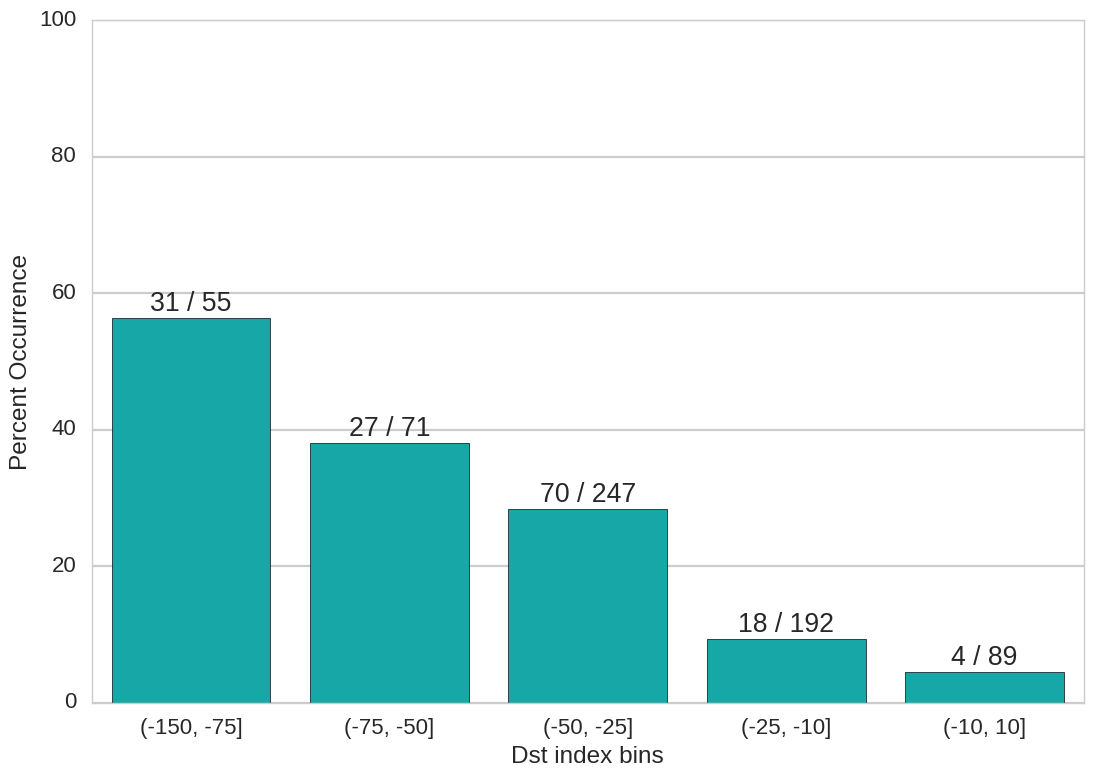

In [14]:
# set seaborn color
sns.set_style("whitegrid")
sns.set_context("poster")
# dstSapsHoursDF = pandas.concat([ \
#                      pandas.value_counts( hourWiseBins ), \
#                      pandas.value_counts( allDataHourWiseBins )],\
#                     axis=1)#.reset_index()
countSaidDstDF.index = countSaidDstDF["dst_bin"]
countSaidDstDF = countSaidDstDF[ [ "saidCount", "allSAPSCount", "percOcc" ] ]
countSaidDstDF = countSaidDstDF.reindex(index = ['(-150, -75]','(-75, -50]',\
                                               '(-50, -25]', '(-25, -10]', '(-10, 10]']).reset_index()
# dstSapsHoursDF.columns = [ "dstRange", "sapsdays", "totaldays" ]
# dstSapsHoursDF["sapsPercent"] = dstSapsHoursDF["sapsdays"]*100/dstSapsHoursDF["totaldays"]
# colors - dodgerblue, lightseagreen, palevioletred, skyblue, c
hoursBar = sns.barplot( countSaidDstDF["dst_bin"], countSaidDstDF["percOcc"], color="c" )
plt.ylim(0, 100)
plt.xlabel("Dst index bins")
plt.ylabel("Percent Occurrence")
for n,p in enumerate(hoursBar.patches):
    titStrg = str( countSaidDstDF["saidCount"][n] ) +\
        " / " + str( countSaidDstDF["allSAPSCount"][n] )
    hoursBar.annotate(
        s= titStrg,
        xy=(p.get_x()+p.get_width()/2.,p.get_height()),
        ha='center',va='center',
        xytext=(0,10),
        textcoords='offset points'
)
fig = hoursBar.get_figure()
fig.savefig("../figs/hoursSAIDSAPSPercent.pdf",bbox_inches='tight')


In [15]:
saidLocsDF = saidDF.groupby( ["dst_bin", "normMLT", "MLAT"] ).count().reset_index()
saidLocsDF = saidLocsDF[ ["dst_bin", "normMLT", "MLAT", "index"] ]
saidLocsDF.columns = ["dst_bin", "normMLT", "MLAT", "count"]
# Now to calculate probability get max counts in each dst Bin
maxDstBinCntSaid = saidLocsDF.groupby( ["dst_bin"] )["count"].max()
maxDstBinCntSaid = maxDstBinCntSaid.to_frame().reset_index().head()
maxDstBinCntSaid.columns = [ "dst_bin", "max_count" ]
saidLocsDF = pandas.merge( saidLocsDF, maxDstBinCntSaid, on=["dst_bin"] )
saidLocsDF["probOcc"] = saidLocsDF["count"]/saidLocsDF["max_count"]
saidLocsDF.head()

,dst_bin,normMLT,MLAT,count,max_count,probOcc
0,"(-10, 10]",-3.0,61.5,1,18,0.055556
1,"(-10, 10]",-3.0,62.0,1,18,0.055556
2,"(-10, 10]",-3.0,62.5,4,18,0.222222
3,"(-10, 10]",-3.0,63.0,2,18,0.111111
4,"(-10, 10]",-3.0,63.5,15,18,0.833333


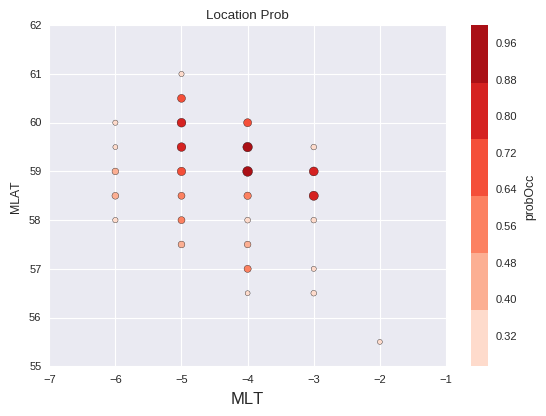

In [16]:
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
subSaidDF1010 = saidLocsDF[ (saidLocsDF["dst_bin"] == "(-75, -50]") &\
                          (saidLocsDF["probOcc"] > 0.25) ]
subSaidDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='probOcc',
              s=subSaidDF1010["probOcc"]*50, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Location Prob" )

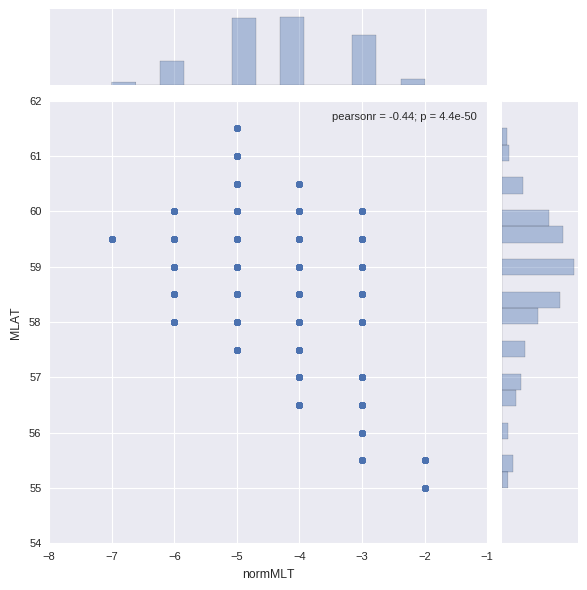

In [17]:
subSaidDF1010 = saidLocsDF[ (saidLocsDF["dst_bin"] == "(-75, -50]") &\
                          (saidLocsDF["probOcc"] > 0.2) ].reset_index(drop=True)
subSaidDF1010 = pandas.merge( saidDF, subSaidDF1010, on=[ "dst_bin", "normMLT", "MLAT" ] )
subSaidDF1010 = subSaidDF1010[ ["dst_bin", "normMLT", "MLAT", "vSapsMax"] ]

sns.jointplot( x="normMLT", y="MLAT", data=subSaidDF1010 )
# g = sns.JointGrid(x="normMLT", y="MLAT", data=subSaidDF1010, space=0)
# g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
# g = g.plot_marginals(sns.kdeplot, shade=True)

In [18]:
# Only consider those locations where prob of observing SAPS is high
# Putting it more appropriately, discard locations where observations
# are low (only keep locations where prob of occ is gt 20%)
highProbSaidDF = saidLocsDF[ saidLocsDF["probOcc"] > 0.2 ].reset_index(drop=True)
highProbSaidDF = pandas.merge( saidDF, highProbSaidDF, on=[ "dst_bin", "normMLT", "MLAT" ] )


saidDstBinDF = highProbSaidDF.groupby( ["dst_bin"] ).median().reset_index()
saidDstBinDF = saidDstBinDF[ [ "dst_bin", "normMLT", "azimMax",\
                              "vSapsMax", "vSaps", "azim", "AE",\
                              "AO", "AL", "AU", "dst_index", "MLAT",\
                              "mlatMax", "mlatMin", "hour" ] ]
saidDstBinDF.head(10)

,dst_bin,normMLT,azimMax,vSapsMax,vSaps,azim,AE,AO,AL,AU,dst_index,MLAT,mlatMax,mlatMin,hour
0,"(-10, 10]",-1.0,-12.38,1361.85,1361.850,-14.385,347.5,-33.5,-239.0,109.0,-8.0,63.5,64.0,60.5,6.0
1,"(-150, -75]",-5.0,-7.81,1440.35,1427.310,-14.420,826.0,-105.0,-527.0,302.0,-96.0,56.5,58.0,53.0,3.0
2,"(-25, -10]",-4.0,-10.94,1257.62,1239.770,-14.800,495.0,-75.0,-325.0,183.0,-19.0,62.5,63.0,57.5,4.0
3,"(-50, -25]",-4.0,-8.68,1271.24,1251.805,-14.095,587.0,-100.0,-402.0,184.0,-41.0,60.0,61.0,55.5,4.0
4,"(-75, -50]",-4.0,-9.39,1319.06,1307.680,-15.090,901.0,-195.0,-642.0,233.0,-57.0,59.0,59.5,54.0,4.0


In [19]:
saidVelsDF = saidDF.groupby( ["dst_bin", "normMLT"] )["vSaps"].mean().reset_index()
saidVelsDF.columns = [ "dst_bin", "normMLT", "meanSAIDVels" ]
saidStdVelsDF = saidDF.groupby( ["dst_bin", "normMLT"] )["vSaps"].std().reset_index()
saidStdVelsDF.columns = [ "dst_bin", "normMLT", "stdSAIDVels" ]
saidVelsDF = pandas.merge( saidVelsDF, saidStdVelsDF, on=["dst_bin", "normMLT"] )
saidVelsDF = saidVelsDF.dropna().reset_index(drop=True)
saidVelsDF.head()

,dst_bin,normMLT,meanSAIDVels,stdSAIDVels
0,"(-10, 10]",-3.0,1492.603333,189.620070
1,"(-10, 10]",-2.0,1427.643529,221.343983
2,"(-10, 10]",-1.0,1254.631846,191.004062
3,"(-10, 10]",0.0,1249.907222,268.963942
4,"(-10, 10]",1.0,1287.813333,204.661209


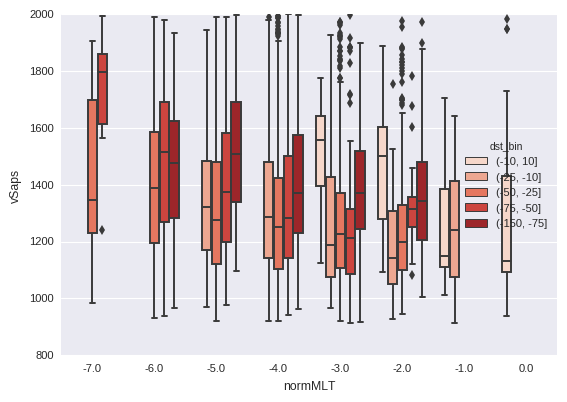

In [20]:
dst_order = [ '(-10, 10]', '(-25, -10]', '(-50, -25]', '(-75, -50]', '(-150, -75]' ]
sns.boxplot( x="normMLT", y="vSaps", hue="dst_bin", data=highProbSaidDF, hue_order=dst_order, palette="Reds" )

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


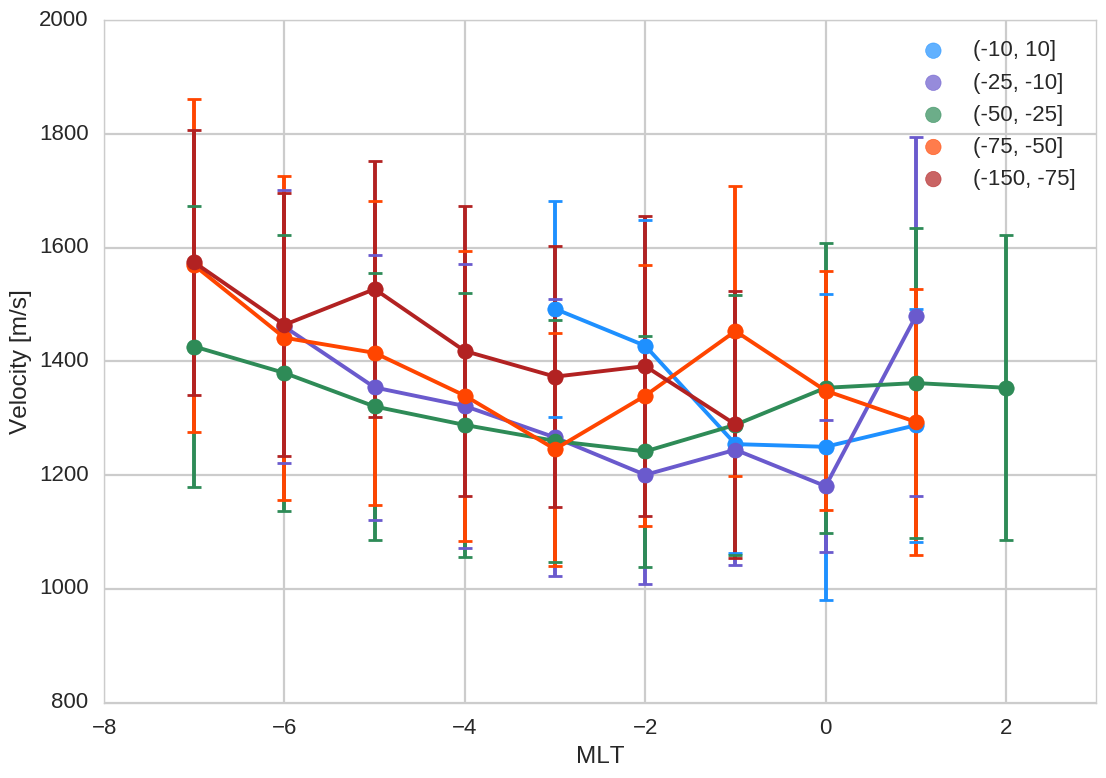

In [21]:

sns.set_style("whitegrid")
sns.set_context("poster")


saidVelsDF["stdSAIDVels"] = saidVelsDF["stdSAIDVels"].fillna(20.)
saidVelsDF = saidVelsDF.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######

plt.scatter(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-10, 10]"],
            saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-10, 10]"],\
             saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-10, 10]"],\
             yerr=saidVelsDF['stdSAIDVels'][saidVelsDF['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o-')




###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
plt.scatter(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-25, -10]"],
            saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
plt.errorbar(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-25, -10]"],\
             saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-25, -10]"],\
             yerr=saidVelsDF['stdSAIDVels'][saidVelsDF['dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='', capthick=2., capsize=5., fmt='o-')


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######

plt.scatter(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-50, -25]"],
            saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
plt.errorbar(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-50, -25]"],\
             saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-50, -25]"],\
             yerr=saidVelsDF['stdSAIDVels'][saidVelsDF['dst_bin'] == "(-50, -25]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o-')



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######



# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-75, -50]"],
            saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-75, -50]"],\
             saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-75, -50]"],\
             yerr=saidVelsDF['stdSAIDVels'][saidVelsDF['dst_bin'] == "(-75, -50]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o-')


# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-150, -75]"],
            saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
plt.errorbar(saidVelsDF['normMLT'][saidVelsDF['dst_bin'] == "(-150, -75]"],\
             saidVelsDF['meanSAIDVels'][saidVelsDF['dst_bin'] == "(-150, -75]"],\
             yerr=saidVelsDF['stdSAIDVels'][saidVelsDF['dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o-')



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
# plt.ylim( [0,1000] )
plt.xlabel("MLT")
plt.ylabel("Velocity [m/s]")
plt.legend()
# plt.savefig("../figs/meanVelMLT-std.pdf",bbox_inches='tight')

In [22]:
saidLocVelsDF = highProbSaidDF.groupby( ["dst_bin", "normMLT", "MLAT"] ).mean().reset_index()
saidLocVelsDF = saidLocVelsDF[ [ "dst_bin", "normMLT", "MLAT", "vSaps", "azim" ] ]
saidLocVelsDF.head()

,dst_bin,normMLT,MLAT,vSaps,azim
0,"(-10, 10]",-3.0,62.5,1479.285000,-15.125000
1,"(-10, 10]",-3.0,63.5,1539.680667,-15.450000
2,"(-10, 10]",-3.0,64.0,1503.800000,-15.030000
3,"(-10, 10]",-3.0,64.5,1486.510909,-14.577273
4,"(-10, 10]",-2.0,63.0,1319.682222,-15.875556


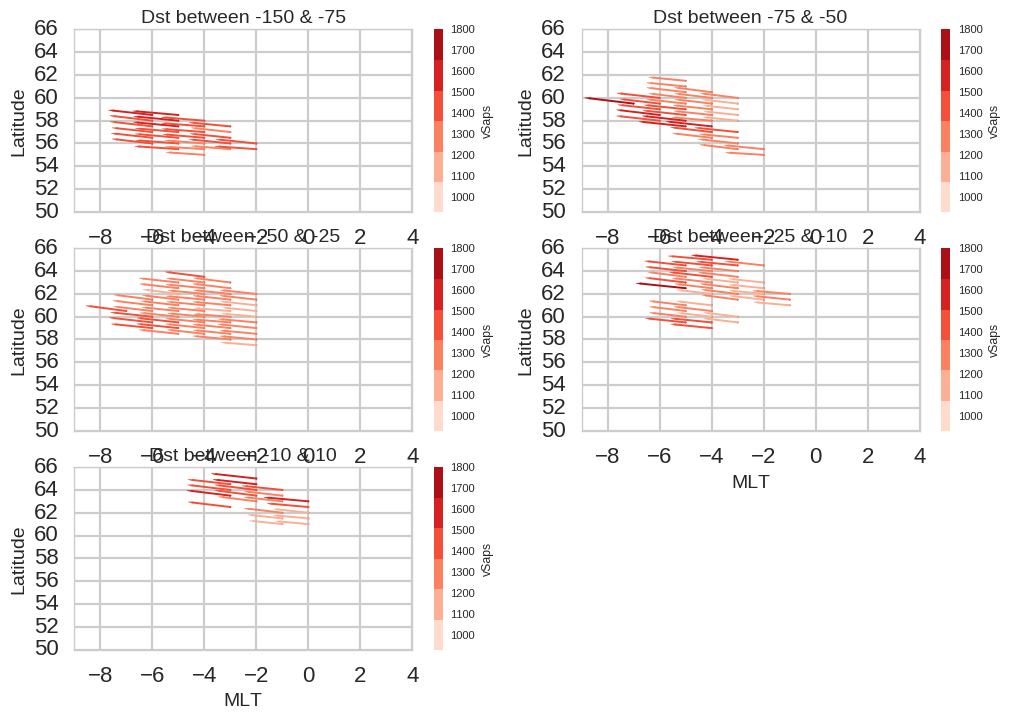

In [23]:

# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
saidLocVelsDF["plot_MLATEnd"] = numpy.round( (saidLocVelsDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*saidLocVelsDF["azim"]) ) +\
                                saidLocVelsDF["MLAT"], 2)
saidLocVelsDF["plot_normMLTEnd"] = numpy.round( (saidLocVelsDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*saidLocVelsDF["azim"]) ) +\
                                saidLocVelsDF["normMLT"], 2)
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = (saidLocVelsDF["vSaps"].min() - 100.)*100/100\
    - (saidLocVelsDF["vSaps"].max() + 100.)%100
# round off max velocity to the next hundred
velScaleMax = (saidLocVelsDF["vSaps"].max() + 100.)*100/100\
    - (saidLocVelsDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = saidLocVelsDF[ saidLocVelsDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)

ax1.set_xlim( [-9, 4] )
ax1.set_ylim( [50, 66] )
ax1.set_xlabel("", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF15075['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = saidLocVelsDF[ saidLocVelsDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF7550['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)

ax2.set_xlim( [-9, 4] )
ax2.set_ylim( [50, 66] )   
ax2.set_xlabel("", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = saidLocVelsDF[ saidLocVelsDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF5025['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)

ax3.set_xlim( [-9, 4] )
ax3.set_ylim( [50, 66] )        
ax3.set_xlabel("", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = saidLocVelsDF[ saidLocVelsDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF2510['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax4.set_xlim( [-9, 4] )
ax4.set_ylim( [50, 66] )
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = saidLocVelsDF[ saidLocVelsDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF1010['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlim( [-9, 4] )
ax5.set_ylim( [50, 66] )
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/saidDstBinsVelVecs.pdf",bbox_inches='tight')